# RSNA Screening Mammography Breast Cancer Detection

**Table of Contents**                                                                      
Step1: Environment Setup                                                                          
Step2: Data Loading and Preparation                                                                      
Step3: Analyzing Class Distribution                                                          
Step4: Data Augmentation for Minority Classes                                                            
Step5: Splitting the Dataset                                                                                     
Step6: Preparing Data Generators                                                             
Step7: Building the Model                                                                                       
Step8: Compiling the Model with Class Weights                                                  
Step9: Implementing Learning Rate Scheduling and Early Stopping                                      
Step10: Training the Model                                                             
Step11: Evaluating the Model                                                                   
Step12: Conclusion and Next Steps                                                           



**Step: 1 Environment Setup**

In [3]:
# Data manipulation and analysis
import os 
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from glob import glob

# Image processing
from PIL import Image
import cv2


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

**Step 2: Loading Data**


In [11]:
# --- CONFIGURATION ---
conf = {
    'ROOT_DIR': '/kaggle/input/rsna-breast-cancer-detection',
    'SAVE_DIR': '/kaggle/working/processed_images'
}

# Create directory if it doesn't exist
os.makedirs(conf['SAVE_DIR'], exist_ok=True)

# Load Train CSV
data = pd.read_csv(f"{conf['ROOT_DIR']}/train.csv")
print(f"Dataset Loaded: {data.shape[0]} images.")

# Add full path to the dataframe for easy access
def get_image_path(patient_id, image_id):
    return f"{conf['ROOT_DIR']}/train_images/{patient_id}/{image_id}.dcm"

data['path'] = data.apply(lambda x: get_image_path(x.patient_id, x.image_id), axis=1)
data.head()

Dataset Loaded: 54706 images.


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...


**3. Analyzing Class Distribution**

In [12]:
image_paths = data['path'].tolist()
print(f"Total image paths collected: {len(image_paths)}")

image_labels = data['cancer'].tolist()
print(f"Total labels collected: {len(image_labels)}")

Total image paths collected: 54706
Total labels collected: 54706


Class counts:
 label
0    53548
1     1158
Name: count, dtype: int64


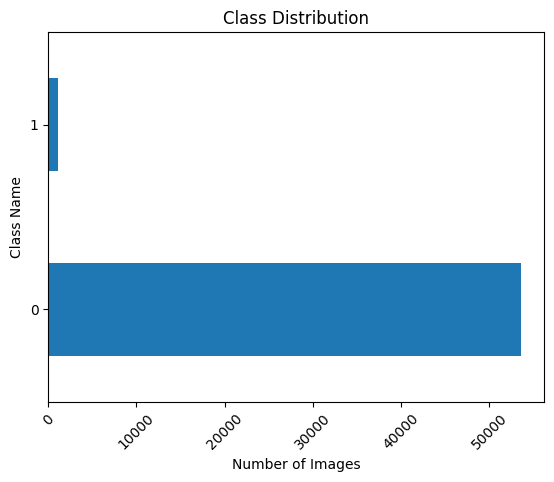

In [13]:
# Create a DataFrame to aid in analysis
df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

# Map numerical labels to class names
#label_to_class = {v: k for k, v in class_to_label.items()}
#df['cancer'] = df['label'].map(label_to_class)

# Display class counts
class_counts = df['label'].value_counts()
print("Class counts:\n", class_counts)

# Plot class distribution
class_counts.plot(kind='barh')
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Class Name')
plt.xticks(rotation=45)
plt.show() 



In [9]:
df.head()

,image_path,label,class_name
0,/kaggle/input/tcga-stomach-histological-images...,0,non-tumour
1,/kaggle/input/tcga-stomach-histological-images...,0,non-tumour
2,/kaggle/input/tcga-stomach-histological-images...,0,non-tumour
3,/kaggle/input/tcga-stomach-histological-images...,0,non-tumour
4,/kaggle/input/tcga-stomach-histological-images...,0,non-tumour


In [10]:
df.tail()

,image_path,label,class_name
28894,/kaggle/input/tcga-stomach-histological-images...,1,tumour
28895,/kaggle/input/tcga-stomach-histological-images...,1,tumour
28896,/kaggle/input/tcga-stomach-histological-images...,1,tumour
28897,/kaggle/input/tcga-stomach-histological-images...,1,tumour
28898,/kaggle/input/tcga-stomach-histological-images...,1,tumour


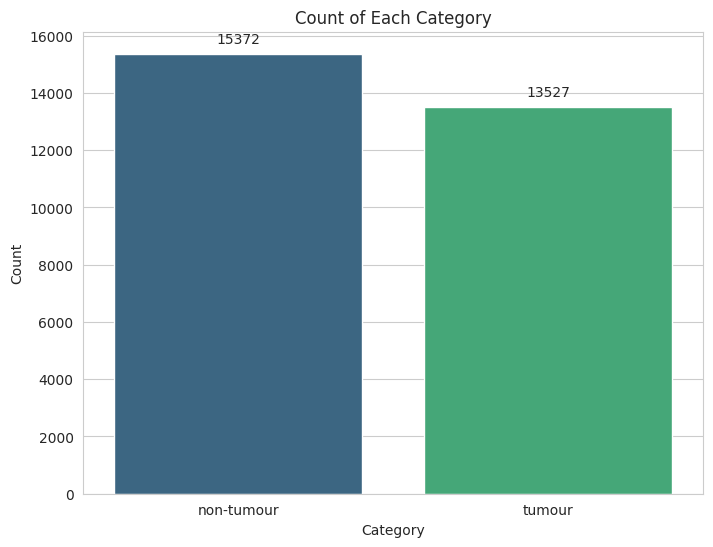

In [28]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.countplot(data=df, x=df['label'].map(label_to_class), palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.title("Count of Each Category")
plt.xlabel("Category")
plt.ylabel("Count")

plt.show()

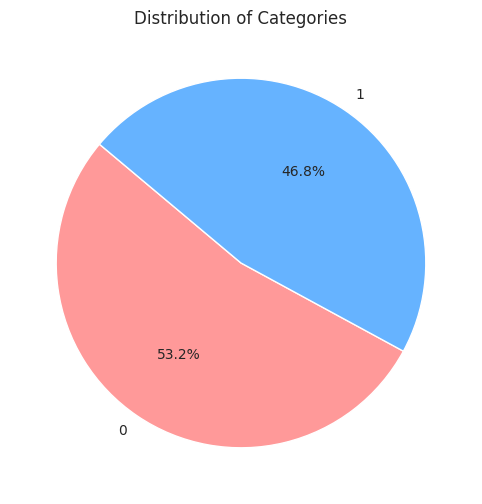

In [31]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])

plt.title("Distribution of Categories")

plt.show() 

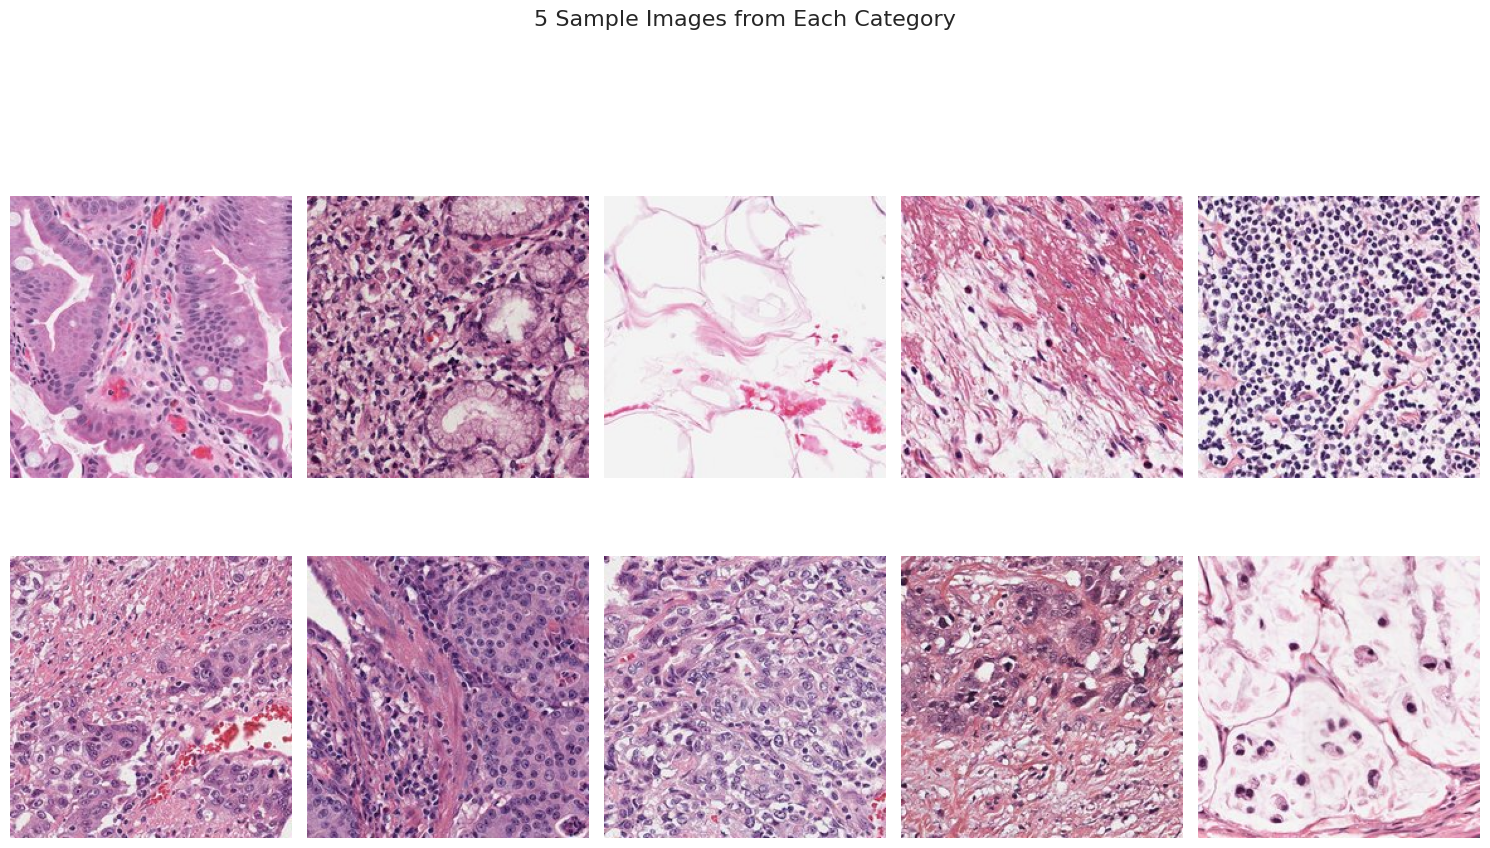

In [32]:
num_images = 5

fig, axes = plt.subplots(len(label_to_class), num_images, figsize=(15, 10))
fig.suptitle("5 Sample Images from Each Category", fontsize=16)

for i, category in enumerate(label_to_class):

    sample_images = df[df['label'] == category].sample(num_images, random_state=42)

    for j, image_path in enumerate(sample_images['image_path']):

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(category, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
     


**4. Data Augmentation for Minority Classes**


In [4]:
# Define augmentation parameters
data_gen_args = dict(
    preprocessing_function=preprocess_input,  # Required for VGG
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [5]:
# Define data augmentation transformations
def balanced_data_generator(df, batch_size, target_size, datagen):
    '''
    A generator that yields batches of images and labels, balancing classes by oversampling minority classes.
    '''
    # Get the class counts
    class_counts = df['label'].value_counts()
    max_count = class_counts.max()
    class_indices = {label: df[df['label'] == label].index for label in class_counts.index}

    while True:
        batch_paths = []
        batch_labels = []

        # Oversample minority classes
        for label, indices in class_indices.items():
            num_samples = max_count - len(indices)
            if num_samples > 0:
                extra_indices = np.random.choice(indices, size=num_samples, replace=True)
                indices = indices.union(extra_indices)

            # Shuffle indices
            indices = np.random.permutation(indices)
            batch_paths.extend(df.loc[indices, 'image_path'].tolist())
            batch_labels.extend(df.loc[indices, 'label'].tolist())

        # Combine and shuffle
        combined = list(zip(batch_paths, batch_labels))
        np.random.shuffle(combined)
        batch_paths, batch_labels = zip(*combined)

        # Yield batches
        for i in range(0, len(batch_paths), batch_size):
            batch_end = min(i + batch_size, len(batch_paths))
            batch_images = []
            batch_labels_one_hot = []

            for j in range(i, batch_end):
                # Load and preprocess the image
                img = Image.open(batch_paths[j]).convert('RGB')
                #img = img.resize(target_size)
                img_array = np.array(img)
                batch_images.append(img_array)
                batch_labels_one_hot.append(to_categorical(batch_labels[j], num_classes=len(classes)))

            # Convert lists to arrays
            X_batch = np.array(batch_images)
            y_batch = np.array(batch_labels_one_hot)

            # Apply real-time data augmentation
            augmented_iterator = datagen.flow(X_batch, y_batch, batch_size=batch_size, shuffle=False)
            X_batch_augmented, y_batch_augmented = next(augmented_iterator)

            # Normalize
            X_batch_augmented = X_batch_augmented / 255.0

            yield X_batch_augmented, y_batch_augmented

**Step 5: Split the Dataset**


In [33]:
# Split into training and temp (validation + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42,
    shuffle = True
)

# Split temp into validation and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42,
    shuffle = True
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")




Training set size: 23119
Validation set size: 2890
Test set size: 2890


**6. Preparing Data Generators**


6.1. Training Data Generator


In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='class_name',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)



Found 23119 validated image filenames belonging to 2 classes.


6.2. Validation Data Generator

In [37]:
valid_gen_new = ts_gen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='class_name',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='class_name',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 2890 validated image filenames belonging to 2 classes.
Found 2890 validated image filenames belonging to 2 classes.


**9. Building and Configuring the VGG Model**

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool1 (MaxPooling2D)              │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2 (MaxPooling2D)              │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool3 (MaxPooling2D)              │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avgpool (GlobalAveragePooling2D)     │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,714 (92.63 KB)

 Trainable params: 23,714 (92.63 KB)

 Non-trainable params: 0 (0.00 B)

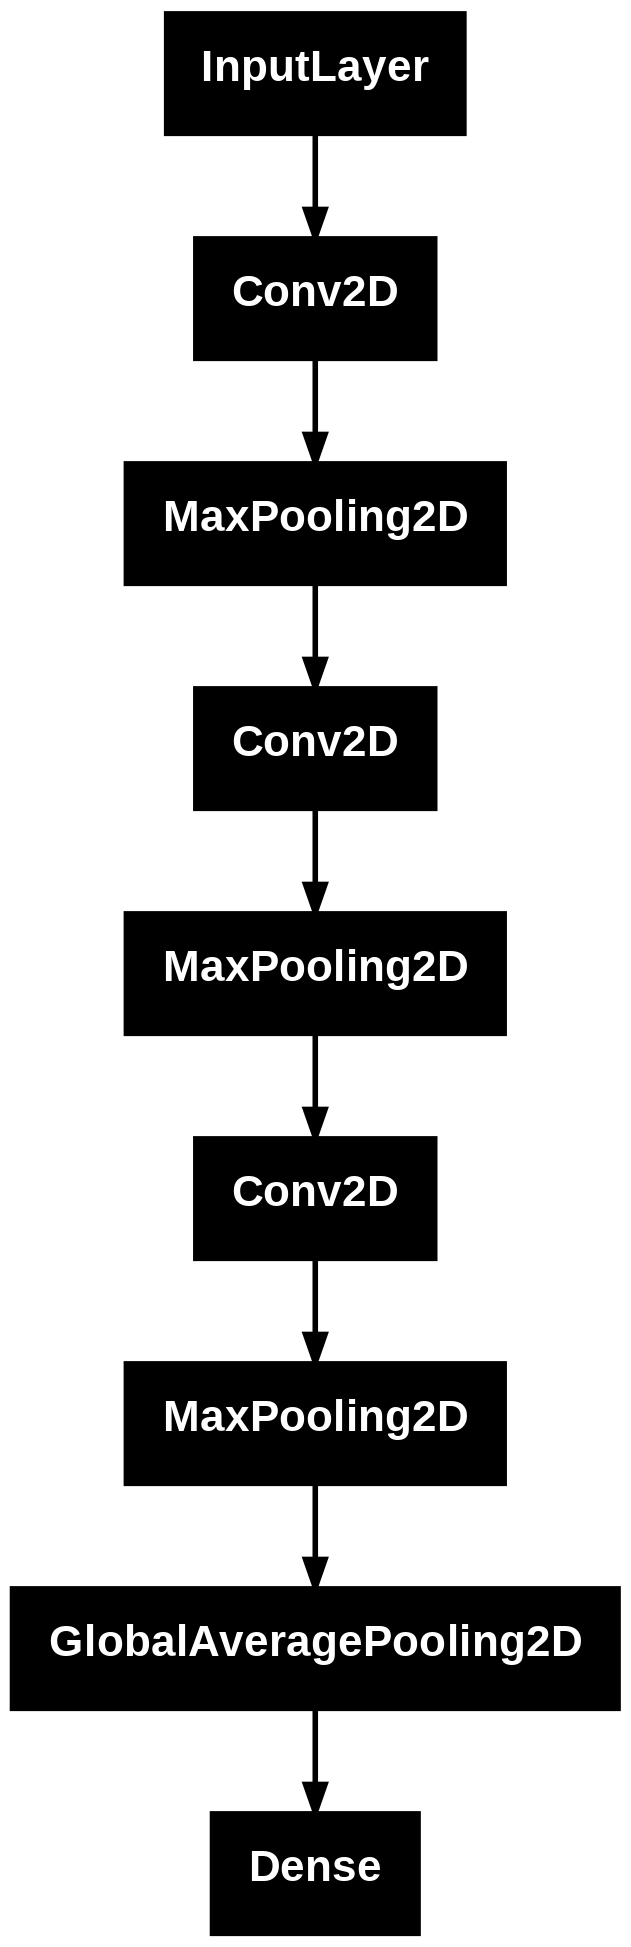

In [51]:
inputs = tf.keras.Input(shape=(224, 224, 3), name='input')

conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, name='conv1')(inputs)
maxpool1 = tf.keras.layers.MaxPooling2D(name='maxpool1')(conv1)

conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, name='conv2')(maxpool1)
maxpool2 = tf.keras.layers.MaxPooling2D(name='maxpool2')(conv2)

conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, name='conv3')(maxpool2)
maxpool3 = tf.keras.layers.MaxPooling2D(name='maxpool3')(conv3)

avgpool = tf.keras.layers.GlobalAveragePooling2D(name='avgpool')(maxpool3)

outputs = tf.keras.layers.Dense(2, activation='softmax', name='output')(avgpool)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()
tf.keras.utils.plot_model(model)



In [57]:
# Compile the model
#tf.keras.losses.binary_crossentropy
model.compile(optimizer= 'adam' , loss=  tf.keras.losses.SparseCategoricalCrossentropy, metrics=['accuracy']) 

In [58]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
)

callbacks = [early_stopping, reduce_lr]

Step 7: Cross-validating model        


In [73]:
steps_per_epoch = len(train_df) * 2 // batch_size  # Oversampling will effectively double the data
# Train the model
history = model.fit(
    train_gen_new,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data= valid_gen_new,  #(X_val, y_val),
    #class_weight=class_weights,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/20
1443/2889 ━━━━━━━━━━━━━━━━━━━━ 56s 39ms/step - accuracy: 0.9046 - loss: 0.2417

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2889/2889 ━━━━━━━━━━━━━━━━━━━━ 64s 22ms/step - accuracy: 0.9056 - loss: 0.2408 - val_accuracy: 0.8737 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 2/20
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 63s 22ms/step - accuracy: 0.9094 - loss: 0.2353 - val_accuracy: 0.8941 - val_loss: 0.2701 - learning_rate: 0.0010
Epoch 3/20
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 64s 22ms/step - accuracy: 0.9070 - loss: 0.2366 - val_accuracy: 0.8903 - val_loss: 0.2786 - learning_rate: 0.0010
Epoch 4/20
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - accuracy: 0.9065 - loss: 0.2391 - val_accuracy: 0.8955 - val_loss: 0.2795 - learning_rate: 0.0010
Epoch 5/20
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - accuracy: 0.9076 - loss: 0.2339 - val_accuracy: 0.8862 - val_loss: 0.3069 - learning_rate: 0.0010
Epoch 6/20
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - accuracy: 0.9112 - loss: 0.2303 - val_accuracy: 0.9017 - val_loss: 0.2568 - learning_rate: 0.0010
Epoch 7/20
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - accuracy: 0.9116 

Step 8: Testing model            


In [74]:
# Saving training history in a dataframe format
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv('training_history_3.csv', index=False)

print("Training history saved to 'training_history_3.csv'")

Training history saved to 'training_history_3.csv'


In [75]:
# Concatinating the history of the model
hist_1 = pd.read_csv('/kaggle/working/training_history_1.csv')
hist_2 = pd.read_csv('/kaggle/working/training_history_2.csv')
hist_3 = pd.read_csv('/kaggle/working/training_history_3.csv')


total_hist = pd.concat([hist_1,hist_2,hist_3],axis=0).reset_index()
total_hist

,index,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0,0.748475,0.536194,0.739100,0.529999,0.001
1,1,0.762057,0.520169,0.751211,0.507632,0.001
2,2,0.770059,0.505175,0.793426,0.488158,0.001
3,3,0.791514,0.471505,0.813841,0.447941,0.001
4,4,0.813573,0.439865,0.829412,0.415975,0.001
...,...,...,...,...,...,...
65,15,0.917384,0.211796,0.898616,0.269071,0.001
66,16,0.919114,0.209203,0.897578,0.277473,0.001
67,17,0.917341,0.209858,0.903114,0.262546,0.001
68,18,0.919503,0.208540,0.906920,0.252262,0.001


In [76]:
# Evaluate the model on the test set
test_steps = len(test_df) // batch_size
test_loss, test_accuracy = model.evaluate(test_gen_new, steps=test_steps)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9090 - loss: 0.2330
Test Accuracy: 90.73%


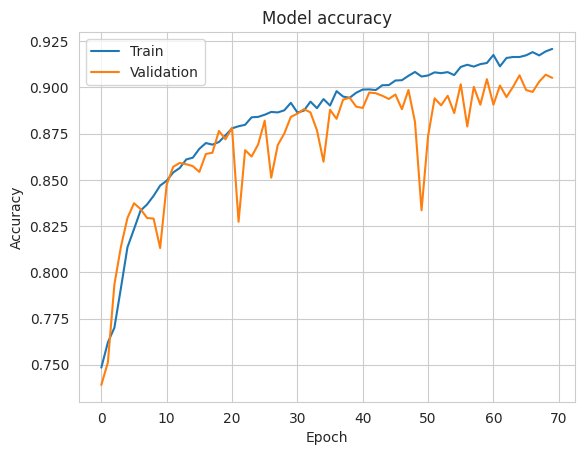

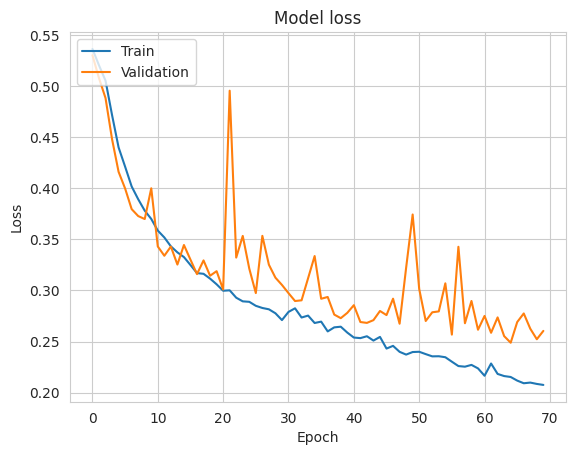

In [77]:
plt.plot(total_hist['accuracy'])
plt.plot(total_hist['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(total_hist['loss'])
plt.plot(total_hist['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [82]:
test_labels = test_gen_new.classes
predictions = model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)
     

report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)
     


181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step
              precision    recall  f1-score   support

  non-tumour       0.91      0.92      0.91      1538
      tumour       0.90      0.90      0.90      1352

    accuracy                           0.91      2890
   macro avg       0.91      0.91      0.91      2890
weighted avg       0.91      0.91      0.91      2890



In [83]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

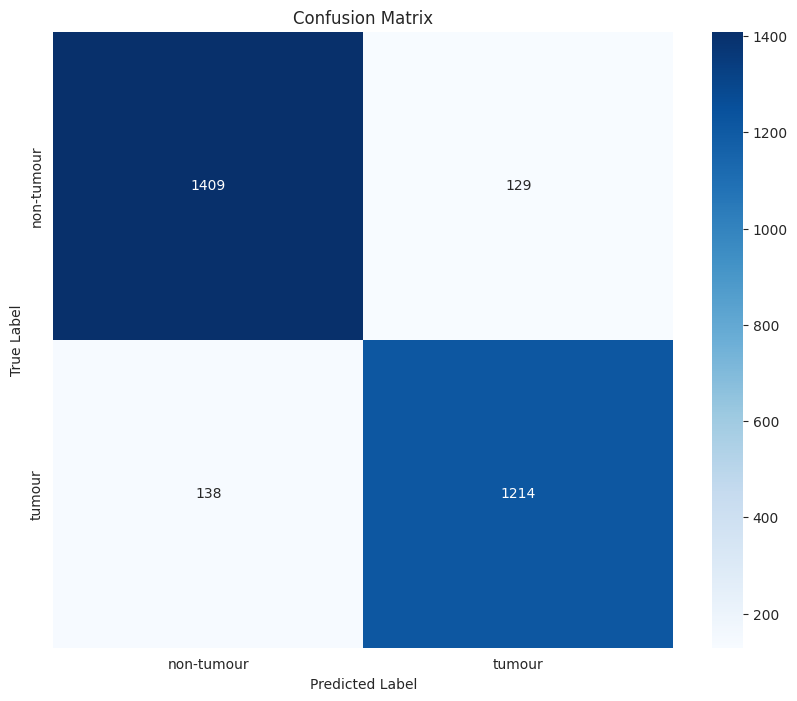

In [84]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()